In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, RocCurveDisplay
from sklearn.feature_selection import RFE

# Install SHAP if not already installed
!pip install shap
import shap

# Load dataset
df = pd.read_csv(r'C:\Users\lenovo slim 3\Desktop\Dissertation\parkinsons_disease_data.csv')


ERROR: Could not find a version that satisfies the requirement shap (from versions: none)
ERROR: No matching distribution found for shap


ModuleNotFoundError: No module named 'shap'

In [19]:
# Identify categorical and numerical columns
categorical_cols = ['DoctorInCharge']
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('UPDRS')

In [20]:
# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Apply preprocessing and feature selection
X_preprocessed = preprocessor.fit_transform(df.drop(columns=['UPDRS']))
rfe = RFE(LinearRegression(), n_features_to_select=10)
rfe.fit(X_preprocessed, df['UPDRS'])
X_selected = rfe.transform(X_preprocessed)


In [21]:
# Split the selected features data
X_train, X_test, y_train, y_test = train_test_split(X_selected, df['UPDRS'], test_size=0.2, random_state=42)

# Regularization with Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("Lasso MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso R² Score:", r2_score(y_test, y_pred_lasso))

Lasso MSE: 2704.095858609453
Lasso R² Score: 0.1913909590706221


In [22]:
# Define the model pipeline for Gradient Boosting without preprocessing since it's already done
gb_pipeline = Pipeline([
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Feature Engineering (Polynomial Features)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [23]:
# GridSearchCV for Gradient Boosting
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_poly, y_train)

# Best Gradient Boosting model after hyperparameter tuning
best_gb_model = grid_search.best_estimator_

Cross-validated R² scores: [0.31604894 0.24660834 0.32848277 0.19922478 0.29456476]
Mean R² score: 0.27698591734435984
Polynomial Gradient Boosting MSE: 2684.746070040412
Polynomial Gradient Boosting R² Score: 0.19717714964784683


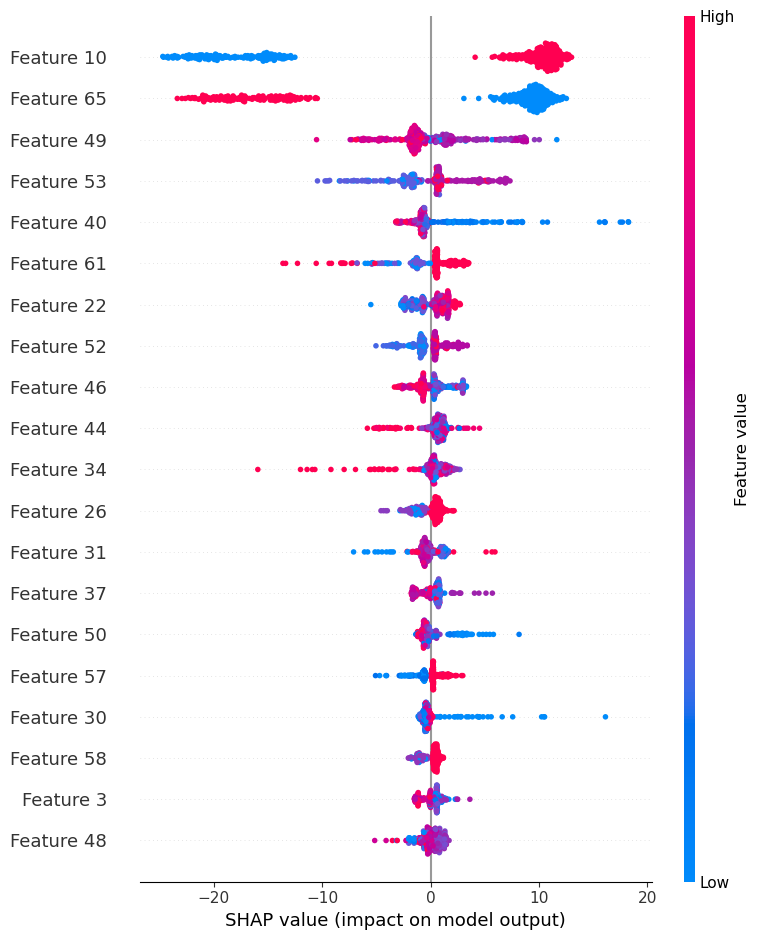

In [24]:
# Cross-Validation on the best model
cv_scores = cross_val_score(best_gb_model, X_train_poly, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R² score: {cv_scores.mean()}")

# Evaluate the tuned Gradient Boosting model on the polynomial features
y_pred_gb_poly = best_gb_model.predict(X_test_poly)
print("Polynomial Gradient Boosting MSE:", mean_squared_error(y_test, y_pred_gb_poly))
print("Polynomial Gradient Boosting R² Score:", r2_score(y_test, y_pred_gb_poly))

# Extract the model from the pipeline
gb_model = best_gb_model.named_steps['regressor']

# Model Interpretation with SHAP
explainer = shap.Explainer(gb_model, X_train_poly)
shap_values = explainer(X_test_poly)
shap.summary_plot(shap_values, X_test_poly)

Cross-validated R² scores: [0.31604894 0.24660834 0.32848277 0.19922478 0.29456476]
Mean R² score: 0.27698591734435984
Polynomial Gradient Boosting MSE: 2684.746070040412
Polynomial Gradient Boosting R² Score: 0.19717714964784683


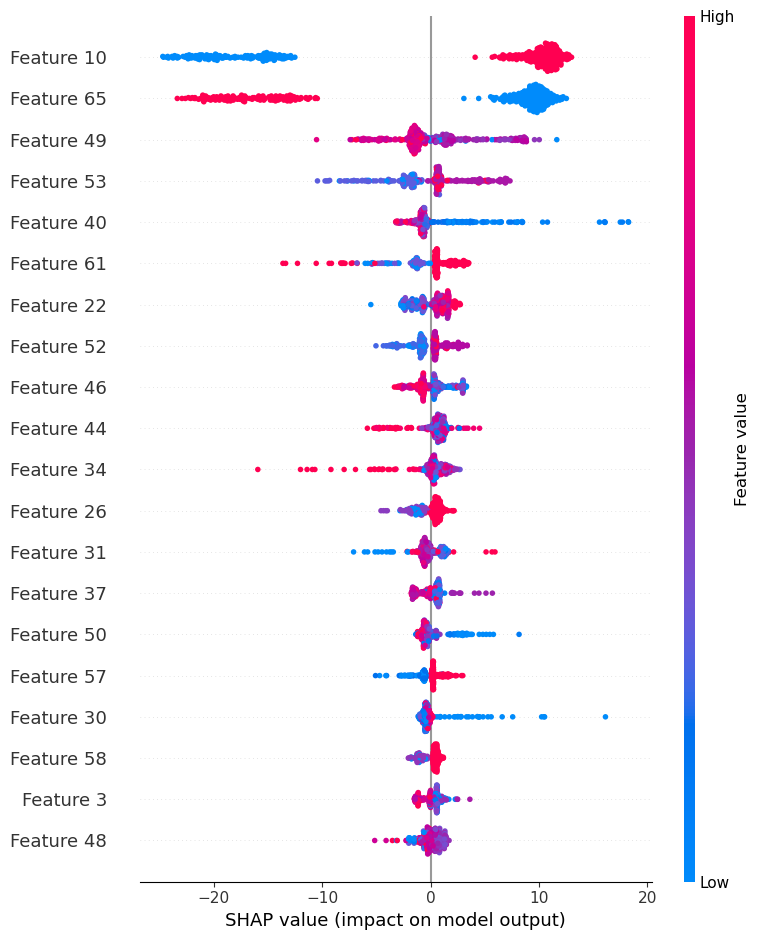

In [24]:
# Cross-Validation on the best model
cv_scores = cross_val_score(best_gb_model, X_train_poly, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R² score: {cv_scores.mean()}")

# Evaluate the tuned Gradient Boosting model on the polynomial features
y_pred_gb_poly = best_gb_model.predict(X_test_poly)
print("Polynomial Gradient Boosting MSE:", mean_squared_error(y_test, y_pred_gb_poly))
print("Polynomial Gradient Boosting R² Score:", r2_score(y_test, y_pred_gb_poly))

# Extract the model from the pipeline
gb_model = best_gb_model.named_steps['regressor']

# Model Interpretation with SHAP
explainer = shap.Explainer(gb_model, X_train_poly)
shap_values = explainer(X_test_poly)
shap.summary_plot(shap_values, X_test_poly)

In [25]:
# Add the tuned Gradient Boosting model to the results for comparison
results = {
    'Linear Regression': (mean_squared_error(y_test, LinearRegression().fit(X_train, y_train).predict(X_test)),
                          r2_score(y_test, LinearRegression().fit(X_train, y_train).predict(X_test))),
    'Random Forest': (mean_squared_error(y_test, RandomForestRegressor(random_state=42).fit(X_train, y_train).predict(X_test)),
                      r2_score(y_test, RandomForestRegressor(random_state=42).fit(X_train, y_train).predict(X_test))),
    'Gradient Boosting': (mean_squared_error(y_test, GradientBoostingRegressor(random_state=42).fit(X_train, y_train).predict(X_test)),
                          r2_score(y_test, GradientBoostingRegressor(random_state=42).fit(X_train, y_train).predict(X_test))),
    'SVR': (mean_squared_error(y_test, SVR().fit(X_train, y_train).predict(X_test)),
            r2_score(y_test, SVR().fit(X_train, y_train).predict(X_test))),
    'Tuned Gradient Boosting': (mean_squared_error(y_test, y_pred_gb_poly), r2_score(y_test, y_pred_gb_poly))
}


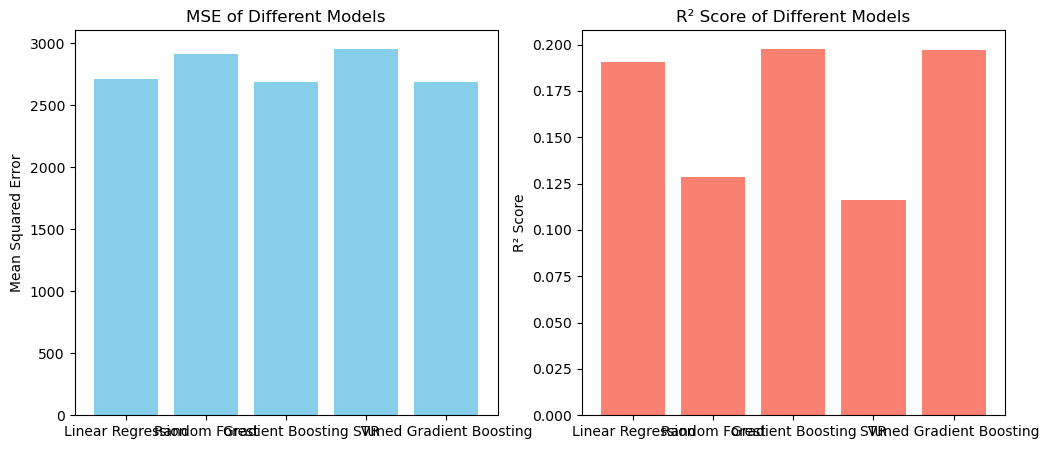

In [26]:
# Visualization (including the tuned Gradient Boosting model)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
models = results.keys()
mse_scores = [result[0] for result in results.values()]
r2_scores = [result[1] for result in results.values()]

ax1.bar(models, mse_scores, color='skyblue')
ax1.set_title('MSE of Different Models')
ax1.set_ylabel('Mean Squared Error')

ax2.bar(models, r2_scores, color='salmon')
ax2.set_title('R² Score of Different Models')
ax2.set_ylabel('R² Score')

plt.show()

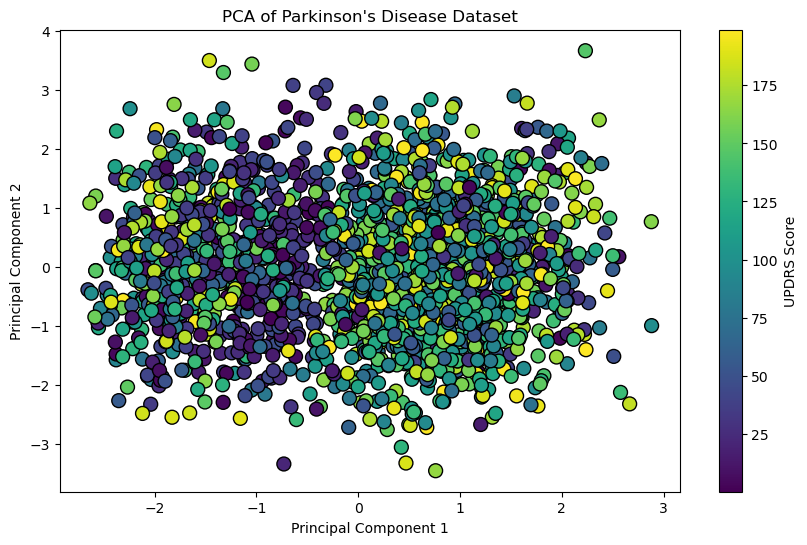

In [27]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['UPDRS'], cmap='viridis', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Parkinson\'s Disease Dataset')
plt.colorbar(label='UPDRS Score')
plt.show()


C:\Users\lenovo slim 3\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


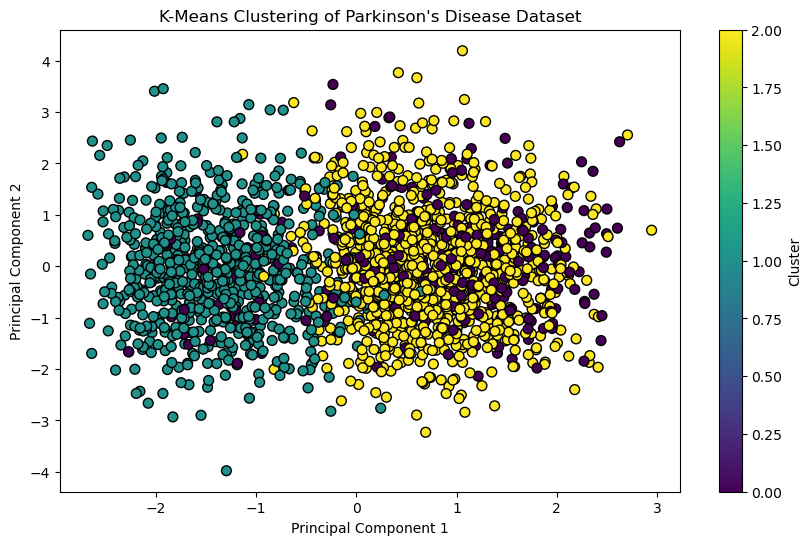

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming X_preprocessed is already defined as the preprocessed dataset
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed)

# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

# Create a scatter plot with the PCA components and clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Parkinson\'s Disease Dataset')
plt.colorbar(label='Cluster')
plt.show()


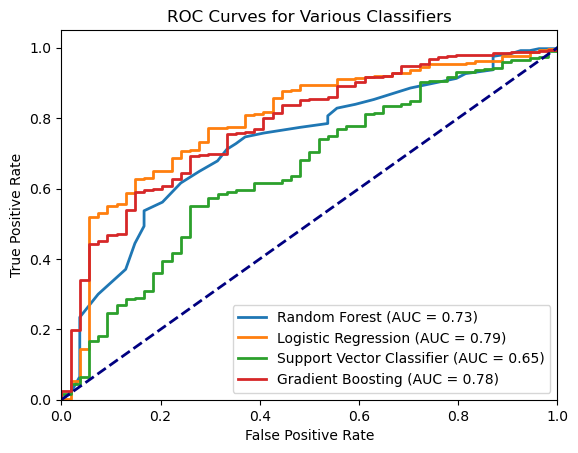

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
# Load dataset
df = pd.read_csv(r'C:\Users\lenovo slim 3\Desktop\Dissertation\parkinsons_disease_data.csv')


# Identify categorical and numerical columns
categorical_cols = ['DoctorInCharge']
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('UPDRS')

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(df.drop(columns=['UPDRS']))
y = df['UPDRS']
threshold = 25  # Define the threshold for binary classification
y_binary = (y > threshold).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_binary, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Plot ROC curves
plt.figure()
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Classifiers')
plt.legend(loc="lower right")
plt.show()


SVR Cross-validated R² scores: [0.00387681 0.00747621 0.00510547 0.00390981 0.00993546]
SVR Mean R² score: 0.006060752232129674
SVR MSE: 3353.8927477130405
SVR R² Score: -0.002918587177173082


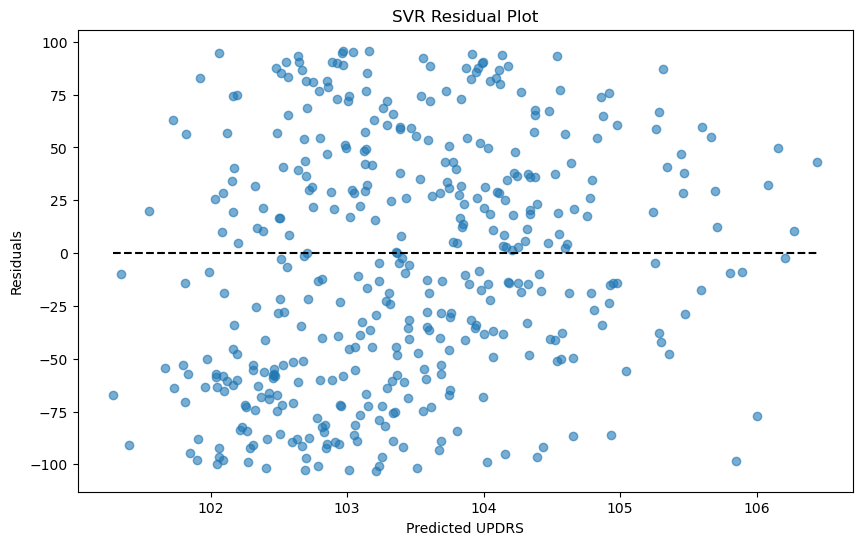

Gradient Boosting Cross-validated R² scores: [0.29760927 0.22663901 0.27335628 0.19282927 0.26731912]
Gradient Boosting Mean R² score: 0.251550589355812
Gradient Boosting MSE: 2738.391458427121
Gradient Boosting R² Score: 0.1811355045576586


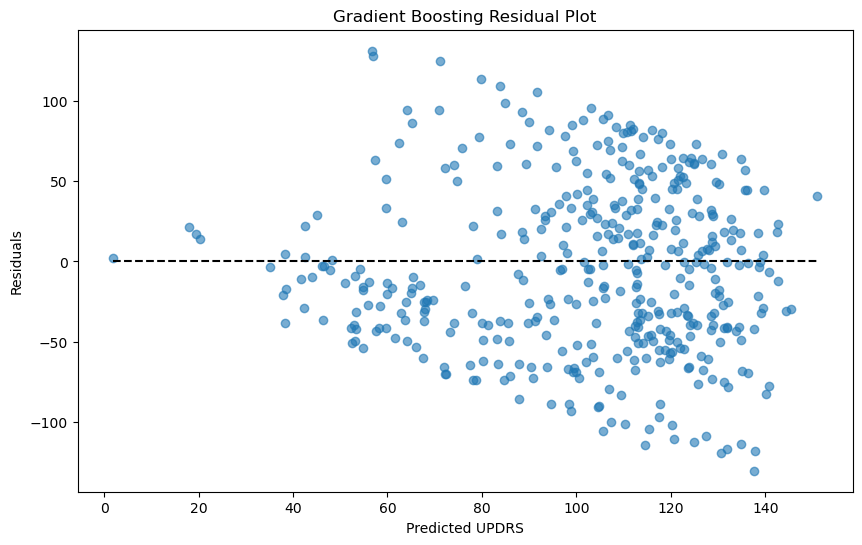

Random Forest Cross-validated R² scores: [0.30503812 0.2149228  0.29320085 0.19137105 0.26024716]
Random Forest Mean R² score: 0.2529559958207609
Random Forest MSE: 2692.4442493064116
Random Forest R² Score: 0.1948751538316248


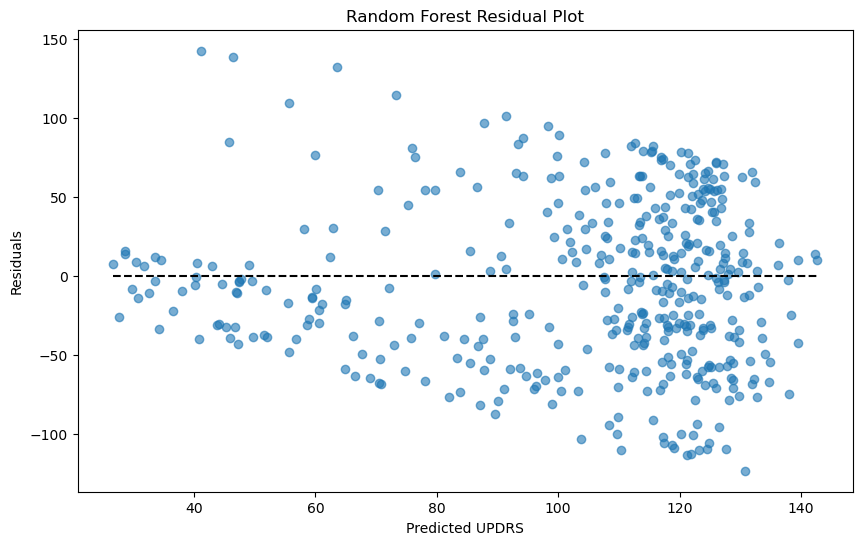

Linear Regression Cross-validated R² scores: [-0.26352072 -0.32711719 -0.33436897 -0.5774385  -0.29020623]
Linear Regression Mean R² score: -0.3585303233559876
Linear Regression MSE: 4060.833026159235
Linear Regression R² Score: -0.21431578995336564


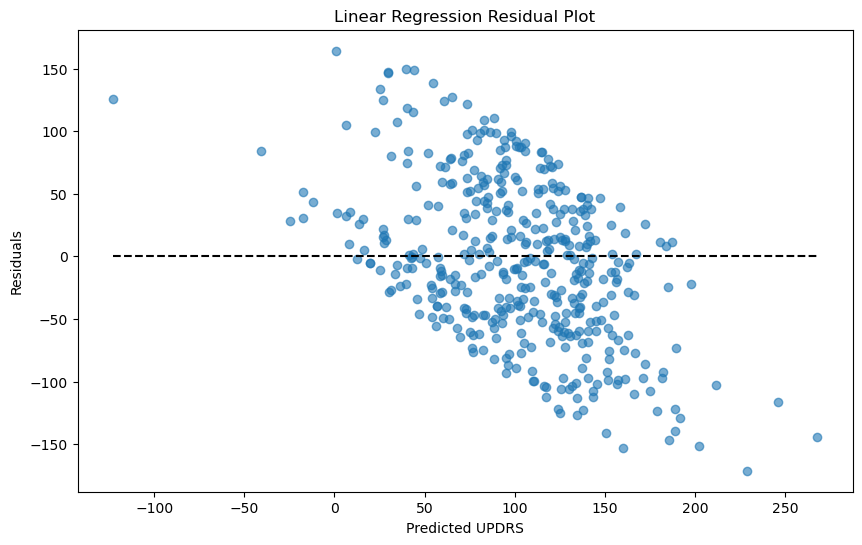

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Identify categorical and numerical columns
categorical_cols = ['DoctorInCharge']
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('UPDRS')

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Polynomial features
poly = PolynomialFeatures(degree=2)

# Prepare training and testing data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['UPDRS']), df['UPDRS'], test_size=0.2, random_state=42)

# Models to evaluate
models = {
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

# Loop through models
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('poly', poly),
        ('regressor', model)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Output metrics
    print(f"{name} Cross-validated R² scores: {scores}")
    print(f"{name} Mean R² score: {scores.mean()}")
    print(f"{name} MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"{name} R² Score: {r2_score(y_test, y_pred)}")

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='black', linestyles='dashed')
    plt.xlabel('Predicted UPDRS')
    plt.ylabel('Residuals')
    plt.title(f'{name} Residual Plot')
    plt.show()


In [36]:
import pandas as pd

# Assuming results is a dictionary containing MSE and R² scores
# Example: results = {'Linear Regression': (mse_lr, r2_lr), 'Random Forest': (mse_rf, r2_rf), ...}

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results, index=['MSE', 'R²']).T

# Display the table
print(results_df)

# Optionally, save the table to a CSV file
results_df.to_csv('model_performance_summary.csv')

# You can also display the table in a formatted way in Jupyter Notebook
from IPython.display import display
display(results_df)


                                 MSE        R²
Linear Regression        2706.795099  0.190584
Random Forest            2914.946680  0.128340
Gradient Boosting        2682.608893  0.197816
SVR                      2955.269789  0.116282
Tuned Gradient Boosting  2684.746070  0.197177


,MSE,R²
Linear Regression,2706.795099,0.190584
Random Forest,2914.946680,0.128340
Gradient Boosting,2682.608893,0.197816
SVR,2955.269789,0.116282
Tuned Gradient Boosting,2684.746070,0.197177


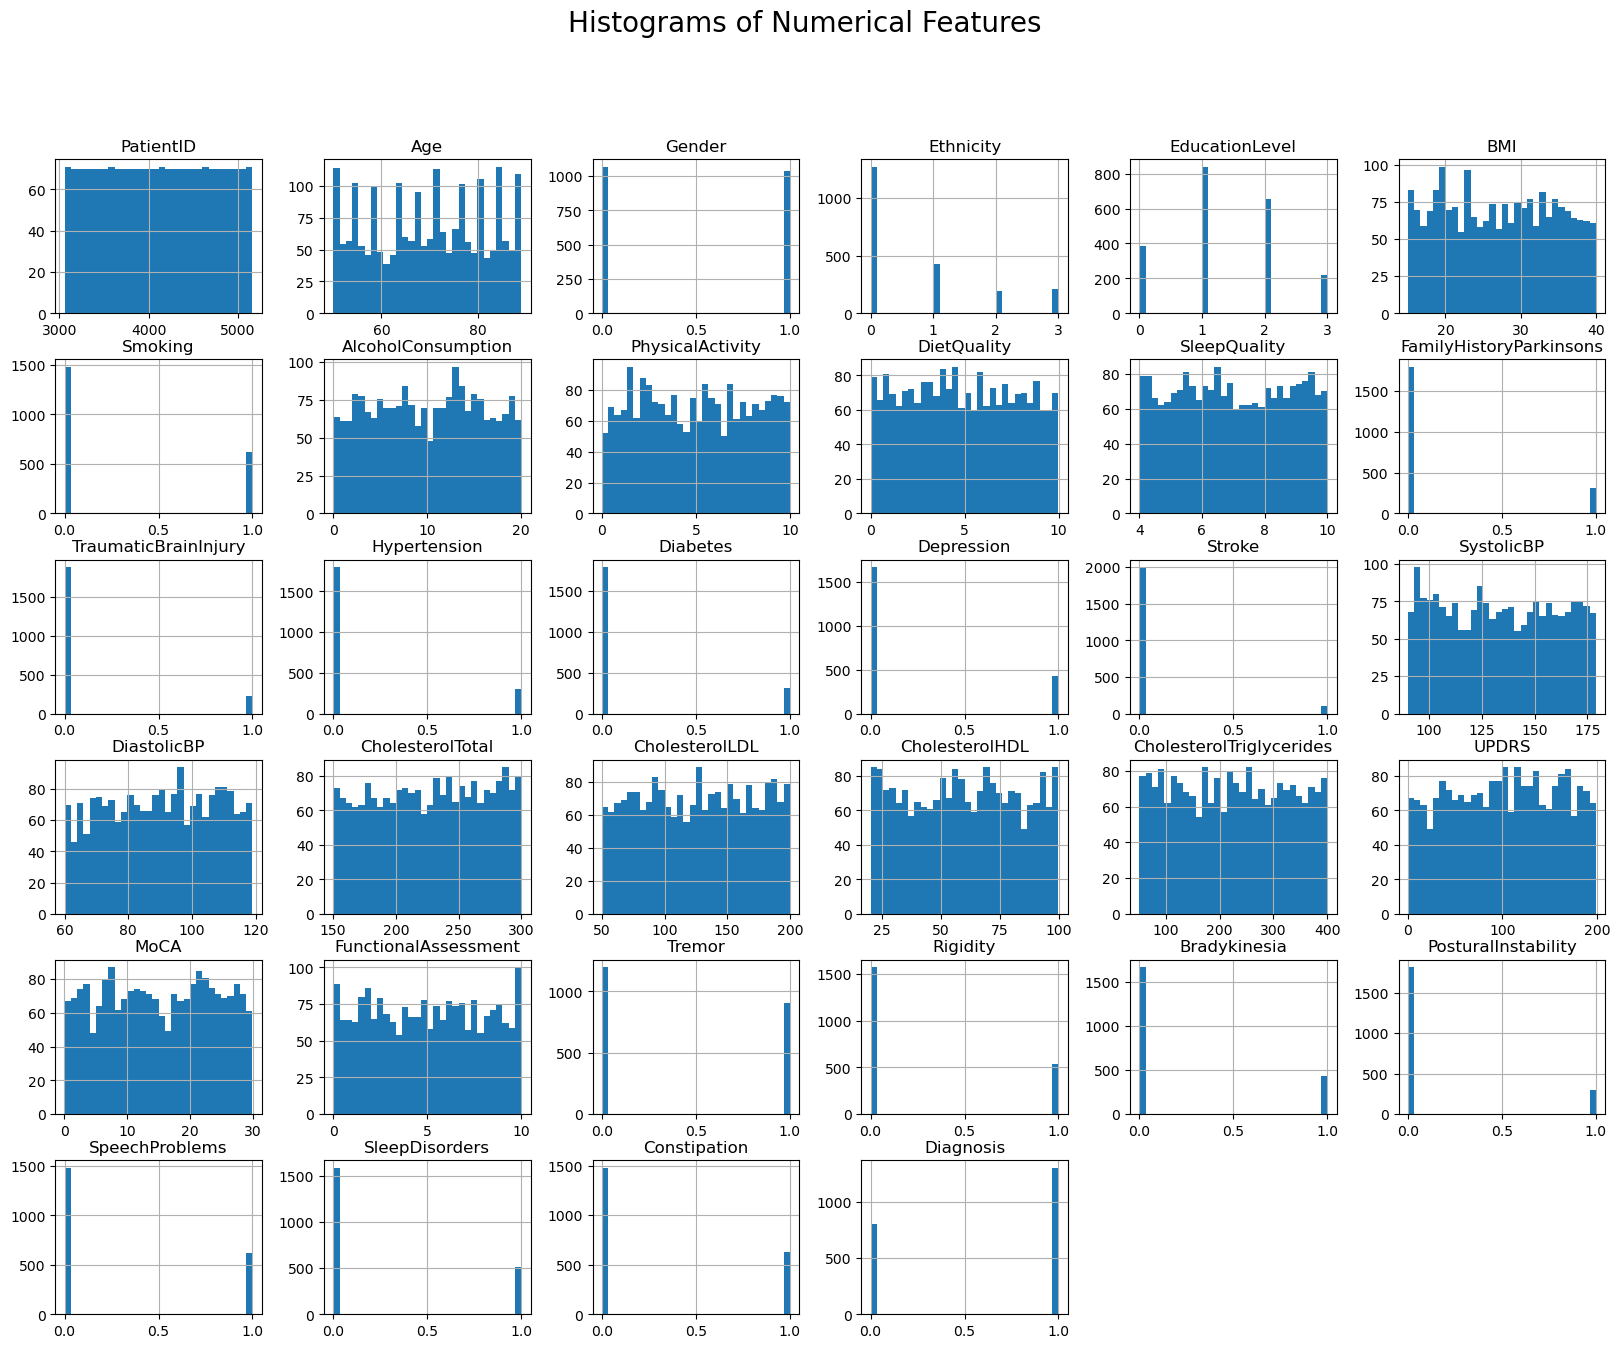

In [37]:
# Plot histograms for numerical features
df.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histograms of Numerical Features', fontsize=20)
plt.show()


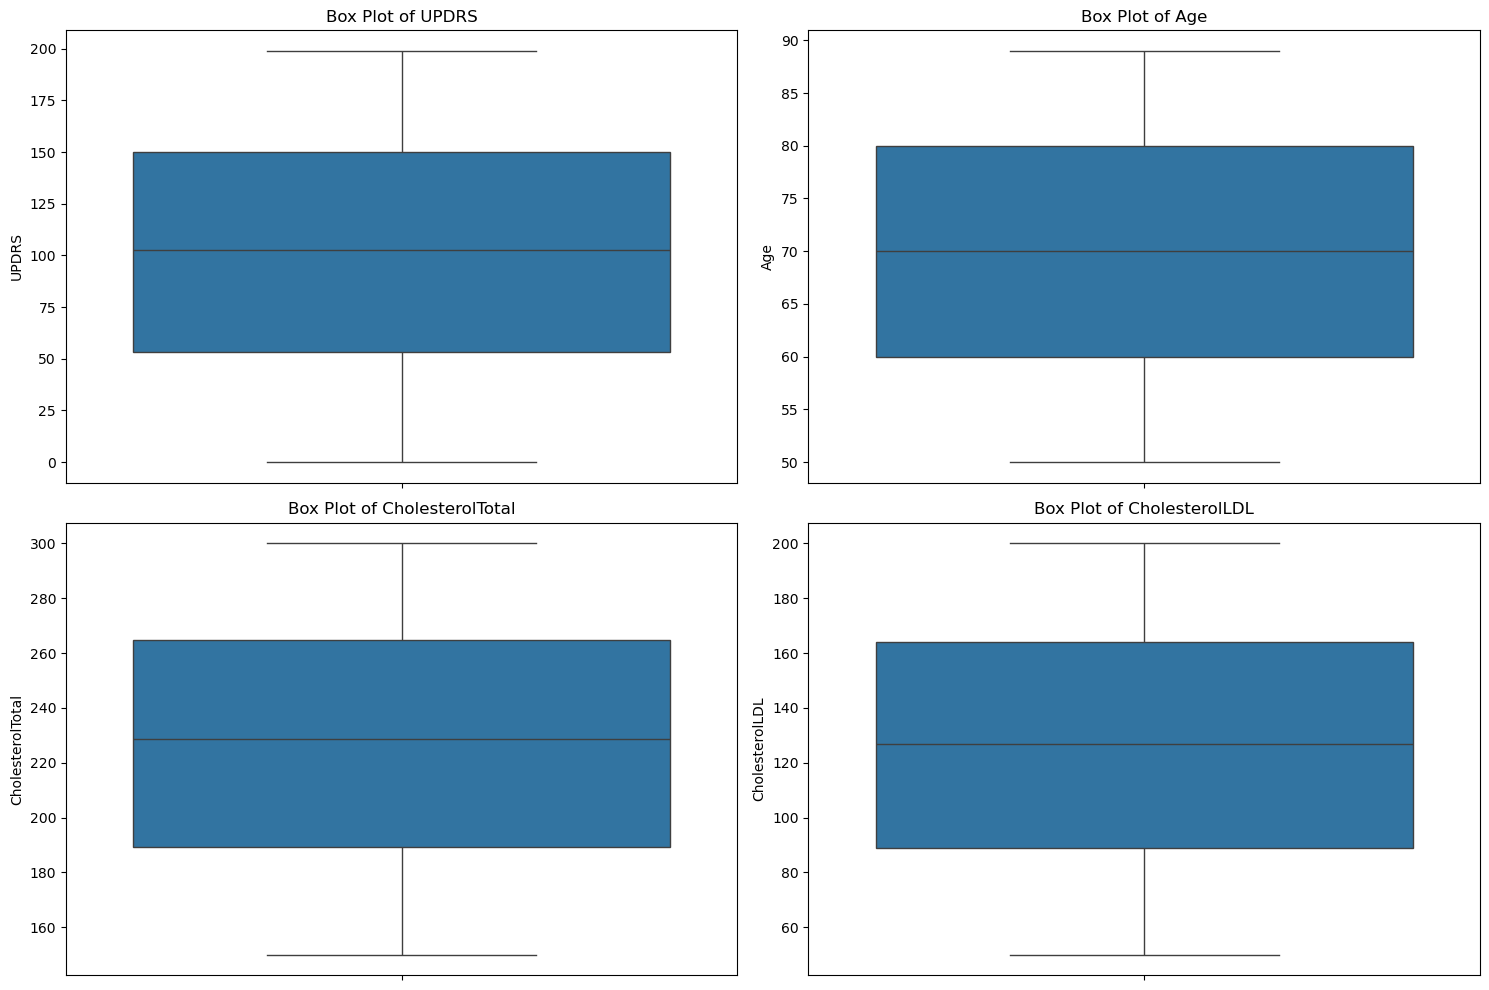

In [38]:
import seaborn as sns

# Selected features for box plots
key_features = ['UPDRS', 'Age', 'CholesterolTotal', 'CholesterolLDL']

# Plot box plots for selected features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()


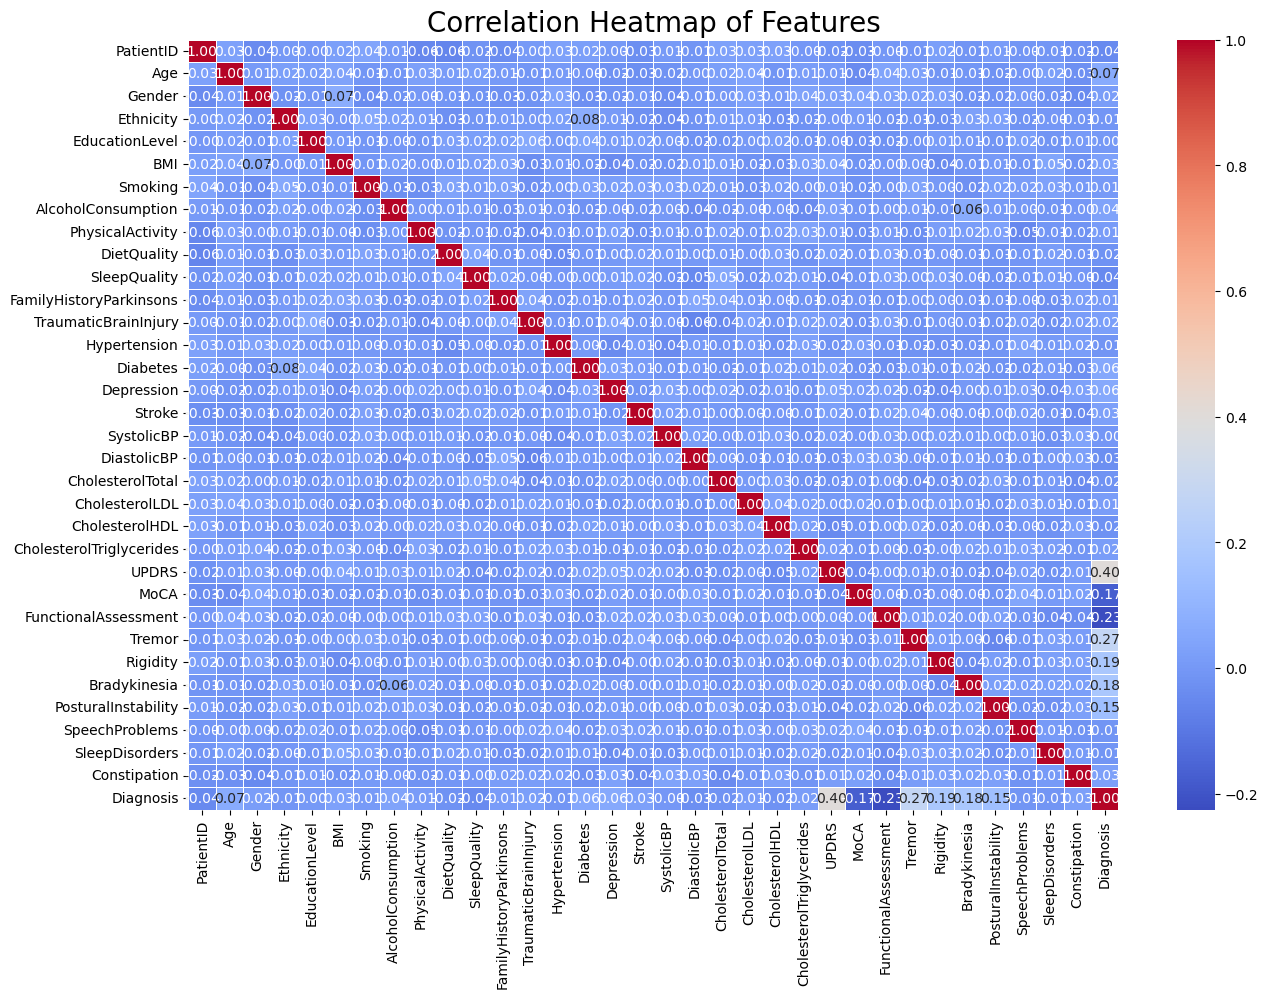

In [39]:
# Exclude non-numeric columns before computing the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=20)
plt.show()
